# Calculate Depth Map using Simple Stereo

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progressbar import progressbar

## Read Image

Text(0.5, 1.0, 'Right Image')

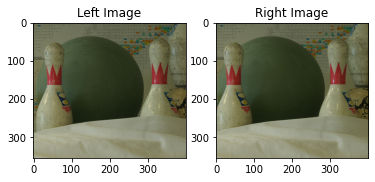

In [2]:
# read images

left_img_gray = cv.imread("left_image.png", cv.IMREAD_GRAYSCALE)
right_img_gray = cv.imread("right_image.png", cv.IMREAD_GRAYSCALE)
left_img_color = cv.imread("left_image.png")
right_img_color = cv.imread("right_image.png")
left_img_color = cv.cvtColor(left_img_color , cv.COLOR_BGR2RGB)
right_img_color = cv.cvtColor(right_img_color , cv.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(left_img_color)
plt.title('Left Image')
plt.subplot(122), plt.imshow(right_img_color)
plt.title('Right Image')


Text(0.5, 1.0, 'Right Image')

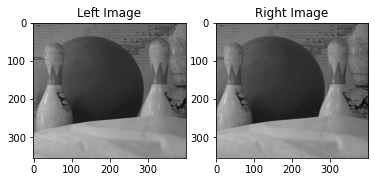

In [3]:
plt.subplot(121), plt.imshow(left_img_gray,'gray')
plt.title('Left Image')
plt.subplot(122), plt.imshow(right_img_gray,'gray')
plt.title('Right Image')

## Image Size

In [4]:
#image size

print(f"Left Image Size is: {left_img_gray.shape}")
print(f"Right Image Size is: {right_img_gray.shape}")

img_height = left_img_gray.shape[0]
img_width = left_img_gray.shape[1]

Left Image Size is: (354, 400)
Right Image Size is: (354, 400)


## Check if we can use 1D search for template matching

(<Axes: >, <matplotlib.image.AxesImage at 0x7fc002242470>)

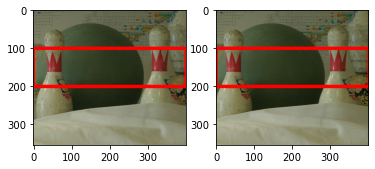

In [5]:
# check if we can perform 1D search for template match

start_point = (0, 100)
end_point = (img_width, 200)

temp1 = cv.rectangle(left_img_color, start_point ,end_point , (255,0,0), 8)
temp2 = cv.rectangle(right_img_color, start_point ,end_point , (255,0,0), 8)
plt.subplot(121) , plt.imshow(temp1)
plt.subplot(122) , plt.imshow(temp2)

## Resize Image

In [6]:
def resize_image(img):
    scale_percent = 5 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return resized


## Depth Calculation

In [7]:
def find_neighbours(i, j, img, filter_size):
    start_i = i - int(filter_size / 2)
    start_j = j - int(filter_size / 2)

    res = np.ones((filter_size, filter_size))

    for i in range(start_i, start_i + filter_size):
        for j in range(start_j, start_j + filter_size):
            res[i - start_i , j - start_j] = img[i, j]

    return res



def NCC(arr1, arr2):

    fbar = np.average(arr1)
    gbar = np.average(arr2)

    fhat = (arr1 - fbar) / np.sqrt( np.sum( np.square(arr1 - fbar) ) )
    ghat = (arr2 - gbar) / np.sqrt( np.sum( np.square(arr2 - gbar) ) )

    return np.sum( np.multiply(fhat, ghat) )


def SSD(arr1, arr2):
    return np.sum(np.square(arr1 - arr2))


def template_matching_NCC(i, j, img1, img2, filter_size, search_range):
    '''
    Given coordinate in img1,
    find coordinate in img2
    '''
    # image info
    height = img2.shape[0]
    width = img2.shape[1]

    # find template
    template = find_neighbours(i, j, img1, filter_size)

    start_index = max(int(filter_size / 2), j - search_range)

    end_index = j

    best_j = start_index
    potential_match = find_neighbours(i, j, img2, filter_size)
    best_score = NCC(template, potential_match)

    for img2_j in range(start_index, end_index):
        potential_match = find_neighbours(i, img2_j, img2, filter_size)
        score = NCC(template, potential_match)
        if score > best_score:
            best_score = score
            best_j = img2_j

    return i, best_j


def template_matching_SSD(i, j, img1, img2, filter_size, search_range):
    '''
    Given coordinate in img1,
    find coordinate in img2
    '''
    # image info
    height = img2.shape[0]
    width = img2.shape[1]

    # find template
    template = find_neighbours(i, j, img1, filter_size)

    start_index = max(int(filter_size / 2), j - search_range)
    end_index = j

    best_j = start_index
    potential_match = find_neighbours(i, j, img2, filter_size)
    best_score = SSD(template, potential_match)

    for img2_j in range(start_index, end_index):
        potential_match = find_neighbours(i, img2_j, img2, filter_size)
        score = SSD(template, potential_match)
        if score < best_score:
            best_score = score
            best_j = img2_j

    return i, best_j


def depth_map(img1, img2, template_matching, MAX_DISPARITY = 30, FILTER_SIZE = 5):

    height = img1.shape[0]
    width = img1.shape[1]

    depth = []

    for i in progressbar( range(int(FILTER_SIZE/2) , height - int(FILTER_SIZE/2)) ):
        #print(f"{i}", flush=True)
        temp = []
        for j in range(int(FILTER_SIZE/2) , width - int(FILTER_SIZE/2)):
            ul = j
            _, ur = template_matching(i, j, img1, img2, FILTER_SIZE, MAX_DISPARITY)
            z = (255 / MAX_DISPARITY) * abs(ul - ur)
            temp.append(z)
        depth.append(temp)

    return np.array(depth)



## Using NCC for template matching

  1% (5 of 350) |                        | Elapsed Time: 0:00:02 ETA:   0:02:44/var/folders/66/vd6zw5p56rjf4rt4h_qfb4900000gn/T/ipykernel_31095/2464461615.py:20: RuntimeWarning: divide by zero encountered in divide
  fhat = (arr1 - fbar) / np.sqrt( np.sum( np.square(arr1 - fbar) ) )
/var/folders/66/vd6zw5p56rjf4rt4h_qfb4900000gn/T/ipykernel_31095/2464461615.py:20: RuntimeWarning: invalid value encountered in divide
  fhat = (arr1 - fbar) / np.sqrt( np.sum( np.square(arr1 - fbar) ) )
  2% (10 of 350) |                       | Elapsed Time: 0:00:04 ETA:   0:02:41/var/folders/66/vd6zw5p56rjf4rt4h_qfb4900000gn/T/ipykernel_31095/2464461615.py:21: RuntimeWarning: divide by zero encountered in divide
  ghat = (arr2 - gbar) / np.sqrt( np.sum( np.square(arr2 - gbar) ) )
/var/folders/66/vd6zw5p56rjf4rt4h_qfb4900000gn/T/ipykernel_31095/2464461615.py:21: RuntimeWarning: invalid value encountered in divide
  ghat = (arr2 - gbar) / np.sqrt( np.sum( np.square(arr2 - gbar) ) )
100% (350 of 350) |#####

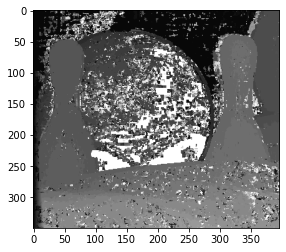

In [8]:
map = depth_map(left_img_gray, right_img_gray, template_matching_NCC)
plt.imshow(map, 'gray')

## Using SSD for template matching

100% (350 of 350) |######################| Elapsed Time: 0:01:01 Time:  0:01:01


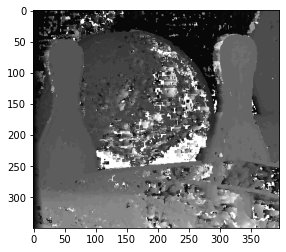

In [9]:
map = depth_map(left_img_gray, right_img_gray, template_matching_SSD)
plt.imshow(map, 'gray')

## Using OpenCV API

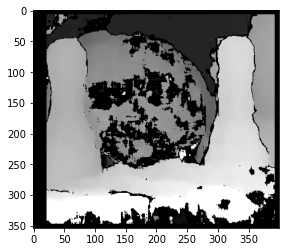

In [10]:
stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_img_gray, right_img_gray)
plt.imshow(disparity,'gray')
plt.show()